In [196]:
import numpy as np
from astropy.convolution import AiryDisk2DKernel
from astropy.convolution import Gaussian2DKernel
from scipy import ndimage
import matplotlib.pyplot as plt

In [197]:
#generates an array of random values bw 0-100 and displays as an image
input_im = np.zeros((108, 108))
#plt.imshow(input_im, cmap='gray')

#creates an array of 1's the same size as input
output_im = np.zeros((108, 108))

In [289]:
#defining variables for noise
RN = 1 #e-
gain = 2.0 #e-/ADU
sky_back = 2.0 #e-/second/pixel
exp_t = 100 #seconds

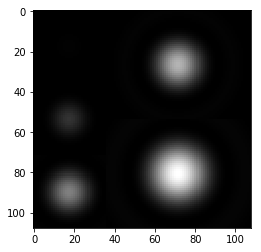

In [290]:
#Make sources and add them to your input array.  
#Make five sources, and have them range in brightness from a peak flux of 0.1 e-/sec to a peak flux of 10.0 e-/sec 
#I'll do (.1, 2, 5, 7, 10)

#making sources of varying radii
source_1 = np.array(AiryDisk2DKernel(12, x_size=36, y_size=36))
source_2 = np.array(AiryDisk2DKernel(15, x_size=36, y_size=36))
source_3 = np.array(AiryDisk2DKernel(18, x_size=36, y_size=36))
source_4 = np.array(AiryDisk2DKernel(20, x_size=72, y_size=54))
source_5 = np.array(AiryDisk2DKernel(25, x_size=72, y_size=54))

#finding the maximum value for each source
max1 = np.amax(source_1)
max2 = np.amax(source_2)
max3 = np.amax(source_3)
max4 = np.amax(source_4)
max5 = np.amax(source_5)

#setting the peak flux of each source by taking (peak flux / maximum val ) * source array
s1 = (.1/max1)*source_1
s2 = (2/max2)*source_2
s3 = (5/max3)*source_3
s4 = ( 7/max4)*source_4
s5 = (10/max5)*source_5 

#stacks the sources on top of each other
s123 = np.vstack((s1, s2, s3))
s45 = np.vstack((s4, s5))

#joins the stacked arrays into one image the same size as input image
s_all = np.c_[s123, s45]

#adds the image to the input array
source_im = input_im + s_all

#plots sources w/o any noise added
plt.imshow(source_im, cmap='gray')

In [291]:
#adding the sky background

#defining function that adds sky background as func of time
def add_sky_back(t):
    return source_im + (sky_back*np.ones((108, 108)))*t

#creates list of arrrays w added sky_back for specified expsoure time
#first element is no sky background added
ims_w_sky = []
for i in range(exp_t+1):
    temp_im = add_sky_back(i)
    ims_w_sky.append(temp_im)

#taking last array w/ the full 100s of sky background noise added
im_sky = ims_w_sky[100]

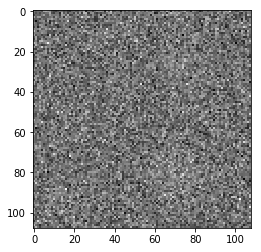

In [292]:
# sampling w poisson stats

#pulls values from poisson dist using lambda= mean of the values of im_sky
lam = np.mean(im_sky)
poisson = np.random.poisson(lam, (108, 108))

#adds poisson noise to sources+sky
im_poisson = im_sky + poisson
plt.imshow(im_poisson, cmap='gray')

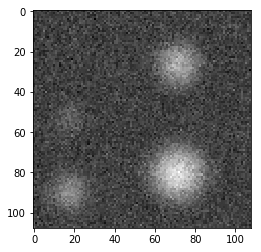

In [293]:
#Now we need to read out the image, adding in read noise as each pixel is read.  

#im going to pretend that the bottom is actually the top
#my loop should:
    #take first line of array
    #read values from left to right of line AND add read noise for each value as its read
    #WHY DO I NEED TO SAMPLE A GAUSSIAN??? ISNT RN JUST 1 E-
    #store new line eachc time in order
    #divide whole new array by gain
    #save that gain array

#defining a function that adds a randomly sampled read noise to a value
def add_rn(val):
    rn_gauss = np.random.normal(0, RN)
    val_w_rn = val+rn_gauss
    return val_w_rn

#first part of first loop picks out the first line and iterates through to the bottom
#second loop picks out each value and adds read noise and then divides by the gain and appends new value to a list
#second part of first loop then takes that list and appends it to empty list
#thus gain_im is a list of list, w size (108, 108)
gain_im = []
for i in range(len(im_sky)):
    first_line = im_sky[i]
    temp_line = []
    for j in range(len(im_sky[i])):
        val = im_sky[i][j]
        new_val = add_rn(val)
        gain_val = new_val/gain
        temp_line.append(gain_val)
    gain_im.append(temp_line)

#plotting my read-out image
plt.imshow(gain_im, cmap='gray')

mean = 101.06901460146996
median = 100.52398822841502
stand. dev. = 1.5220651580102615


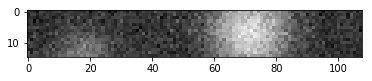

In [294]:
#slice through source
#lines 75-90
source_cut = gain_im[74:89]
plt.imshow(source_cut, cmap='gray')

source_mean = np.mean(source_cut)
print('mean =', source_mean)

source_med = np.median(source_cut)
print('median =', source_med)

source_std = np.std(source_cut)
print('stand. dev. =', source_std)

mean = 100.04150387696959
median = 100.03735416999322
stand. dev. = 0.4964912280742078


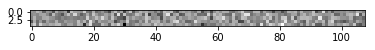

In [295]:
#slice thru only noise
#lines 0-5
noise_cut = gain_im[0:5]
plt.imshow(noise_cut, cmap='gray')

noise_mean = np.mean(noise_cut)
print('mean =', noise_mean)

noise_med = np.median(noise_cut)
print('median =', noise_med)

noise_std = np.std(noise_cut)
print('stand. dev. =', noise_std)

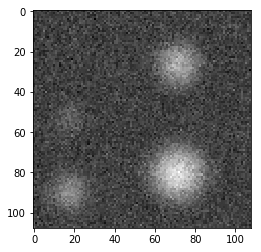

In [296]:
#determing sky val and subtracting it from image

#goal: isolate bottom square of my array
#selecting last few lines of array
bottombit = gain_im[94:]

#selecting last values of each line and creating list of list, ie my bottom square
sky_values = []
for i in range(len(bottombit)):
    line = bottombit[i]
    lastbit = line[94:]
    sky_values.append(lastbit)

#finding avg value of bottom square and subtracting that from gain_im
mean_sky = np.mean(sky_values)
final_im = gain_im - mean_sky

#plotting final science image (after sky subtracted)
plt.imshow(final_im, cmap='gray')

In [297]:
#ANALYSIS SECTION

In [298]:
#1) Calculate the signal-to-noise of your sources.
#You know the signal values, as they are the total value of the objects you created.  
    #For example, for my object with a peak input flux of 1 e-/sec, 
    #the total flux over all pixels in that object is ~2800 e- (in the 100 second integration).

#defining signal values for the sources (Sstar1...5 = sig1...sig5) in units of e-
sig1 = (exp_t*.1)*(np.pi*(25))
sig2 = (exp_t*2)*(np.pi*(25))
sig3 = (exp_t*5)*(np.pi*(25))
sig4 = (exp_t*7)*(np.pi*(25))
sig5 = (exp_t*10)*(np.pi*(25))

In [305]:
#2) Calculate the noise per source, using what you learned about the signal to noise equation in class.  
#Assume that you are measuring the source in an aperture of radius = 5 pixels, 
    #and use the actual number of sky pixels you used above.

def SNR(t, Sstar, npix, nsky, Ssky, DC, RN):
    return (Sstar * t)/np.sqrt((Sstar*t) + npix*((1 + (npix / nsky))*((Ssky * t) + (DC * t) + RN**2)))

npix = 25*np.pi #num of pixel in radius of 5
nsky = 196 #(that is the bottombit square) 
Ssky = sky_back*exp_t #e- per pixel per second * secs of exposure
DC = 0 #no value provided
t = 1 #if Sstar and Ssky are already in units of e-, then we don'y multiply by exp_t
#RN defined in beginning

snr1 = SNR(t, sig1, npix, nsky, Ssky, DC, RN)
snr2 = SNR(t, sig2, npix, nsky, Ssky, DC, RN)
snr3 = SNR(t, sig3, npix, nsky, Ssky, DC, RN)
snr4 = SNR(t, sig4, npix, nsky, Ssky, DC, RN)
snr5 = SNR(t, sig5, npix, nsky, Ssky, DC, RN)

In [300]:
#3) List your signal-to-noise values, and be sure to indicate which sources correspond to which values.  
#Comment on whether the SNR values agree with your by-eye inspection of the sources in your sky-subtracted output image.

print("SNR for Source 1 = ", snr1)
print("SNR for Source 2 = ", snr2)
print("SNR for Source 3 = ", snr3)
print("SNR for Source 4 = ", snr4)
print("SNR for Source 5 = ", snr5)

#Source 1 is the source that lies in the upper left corner of my image, 
    #which is hidden from our eyes both in the source image and in the final image
    #so it makes sense that it has a relatively low SNR
    #but it still higher than an SNR of 1 or 2, so the source is still "detected" by the code in the final image as a signal
#All sources 2-5 are bright enough to see in the final image so they should have relatively large SNR's
    #which they do, with the largest and brightest source (5), having an SNR of ~250

SNR for Source 1 =  5.190310580423446
SNR for Source 2 =  80.77132859119534
SNR for Source 3 =  158.50333329196732
SNR for Source 4 =  198.0105047605524
SNR for Source 5 =  247.55875184853755


In [306]:
#4) For each of your five sources, compare the signal to the noise terms.  
#Are they in the:
    #signal (Sstar > Ssky, DC, RN) or
    #sky (Ssky > Sstar, DC, RN) or
    #read-noise (RN > Sstar, Ssky, DC) 
#dominated regime?

#printing values in units of e- for each term to compare
print("S_star for sources 1-5 =", sig1, sig2, sig3, sig4, sig5)
print('S_sky =', Ssky*nsky)
print('RN = ', RN)
print('DC =', DC)

#my signals are too large for any source to come close to falling into the RN dominated regime

#for the first 2 sources, they are in the sky-noise dominated regime b/c the S_sky >> signal 1 or signal 2
#for the third source, S_sky ~ signal 3, but b/c the signal is slightly larger, it falls into the signal dominated regime
#for the last 2 sources, signal 4 or signal 5 >> S_sky and thus they fall into the signal dominated regime as well

S_star for sources 1-5 = 785.3981633974483 15707.963267948966 39269.90816987242 54977.871437821384 78539.81633974484
S_sky = 39200.0
RN =  1
DC = 0


In [302]:
#5) Play around with increasing the exposure time, 
    #and explore whether the SNR you find for your deeper images scales with time as you would expect 
    #based on the regime you are in.
    
#I increased the exposure time to 200s and got:
    #SNR for Source 1 =  7.3445277009518035
    #SNR for Source 2 =  114.26859693870695
    #SNR for Source 3 =  224.20675025813532
    #SNR for Source 4 =  280.0780641364447
    #SNR for Source 5 =  350.1477880285065

#increasing to 1000s I got:
    #SNR for Source 1 =  16.446778526973354
    #SNR for Source 2 =  255.73732366053898
    #SNR for Source 3 =  501.61330107410026
    #SNR for Source 4 =  626.5438362902003
    #SNR for Source 5 =  783.2129620238751
    
#So, as you increase exposure time, the SNR increasing as well, although not linearly b/c some of the noise (ie dark current)
    #depends on time rather than just the CCD itself 
    
#Even though the SNR's got better the final science image didn't change in appearance